## ACS Pipeline Example Use 
**NGC 104 (47 Tuc)**
<br/>
This notebook provides an exmaple of how to process photometry from the Hubble Space Telescope Advanced Camera for Surveys Galactic Globular Cluster Treasury program using the ACS pipeline. The goal of the photometric pre-processing is to clean up the photometry and reformat for use with the Bayesian analysis software BASE-9. Additionally, this pipeline provides tools to examine the results of the BASE-9 analysis.
<br/><br/>
First, we set up the Jupyter notebook with the usual packages.

In [1]:
%matplotlib inline
from pylab import *
from numpy import *
from random import *
from scipy import *
from matplotlib import *

rcdefaults()
matplotlib.rc('font',family='Bitstream Vera Serif')

<br/>
Next, we import the pipeline package and set the directory (basefolder) which has the necessary files for the preprocessing -- specifically, a 'basefolder/NGC0104/' folder which has the raw 'NGC0104R.RDVIQ.cal.adj.zpt' photometry file from the ACS globular cluster treasury.

In [2]:
%run ACSpipe.py
basefolder='.'

<br/>
Now, we can initiate the pipeline for our example cluster, NGC0104 (aka - 47 Tuc).

In [3]:
clusterval1='0104'  ### notice we leave off the 'NGC', which is an assumed prefix.
ACSpipe1=ACSpipeline(clusterval1, basefolder)

<br/>
### Pre-Processing for BASE-9 Analysis
The first thing to do is look at all of the photometry! We use checkHB() to examine the raw data.

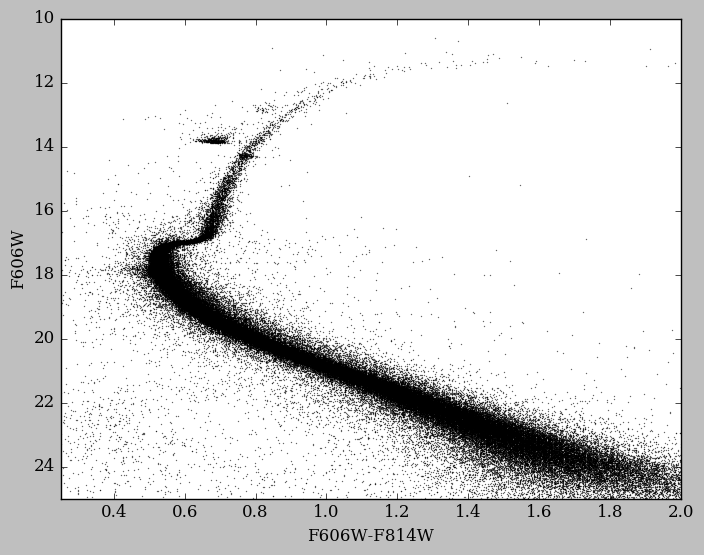

In [4]:
xlim(.25,2);ylim(10,25)
ACSpipe1.checkHB(showplt='yes')

<br/>
Beautiful photometry to work with (thanks, HST!).

Next, we identify the location of the HB and decide to make cuts to get rid of stars brighter than 14 in F606W magnitude and bluer than 0.75 in F606W-F814W color. Using these restrictions with make_cuts(), this gets rid of the bulk of the HB. We also get rid of stars bluer than 0.35 beyond the faint end of the main sequence - this helps to clean up the data a bit more.

This step also removes stars with high photometric errors and high pixel shifts shifts from frame-to-frame in the HST images.

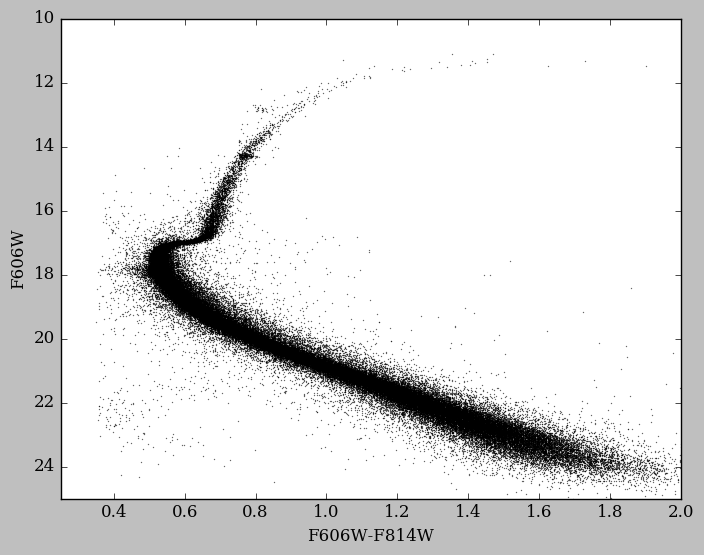

In [5]:
xlim(0.25,2);ylim(10,25)
ACSpipe1.make_cuts(14,.75,26,.35,showplt='yes')

<br/>
Now we have a cleaned set of photometry ready to be formatted for BASE-9 input .phot file format. The reformat_phot() function below reformats the photometry and creates two files in the NGC0104 folder - one with all of the stars (NGC0104.allACS.phot) and one with the cleaned set of stars (NGC0104.cleanedACS.phot).

In [6]:
ACSpipe1.reformat_phot()

'Complete'

<br/>
Next, we can now use the function subsample_phot() to randomly select a sample of stars to use with BASE-9 (since running all of the tens or hundreds of thousands of stars in the clusters would be pretty expensive computationally!). In this example, we randomly sample n=3000 stars (which is the default), with half of this sample coming from stars brighter than the F606W MSTOP magnitude (18.5) and the remainder from the stars fainter than the MSTOP.

A faint limit for the randomly sampled stars is imposed at a F606W magnitude of 20.37. This limit avoid atmospheric modeling issues from the physics-based theoretical models in the lower main sequence dwarfs. Scaling the faint limit with the distance of the cluster allows for a consistent choice when analyzing a population of clusters.

The file 'NGC0104.sampleACS.phot' will be created in the 'NGC0104' folder.

In [7]:
ACSpipe1.subsample_phot(18.5, magcutTOP=7+13.37, n=3000) ### 13.37 is the distance modulus to NGC 104

N* above MSTOP  1500
N* below MSTOP  1500
N* total sample 3000


<br/>
Below, we check this final pre-processing result - with the green stars indicating the randomly selected sample from the previous step.

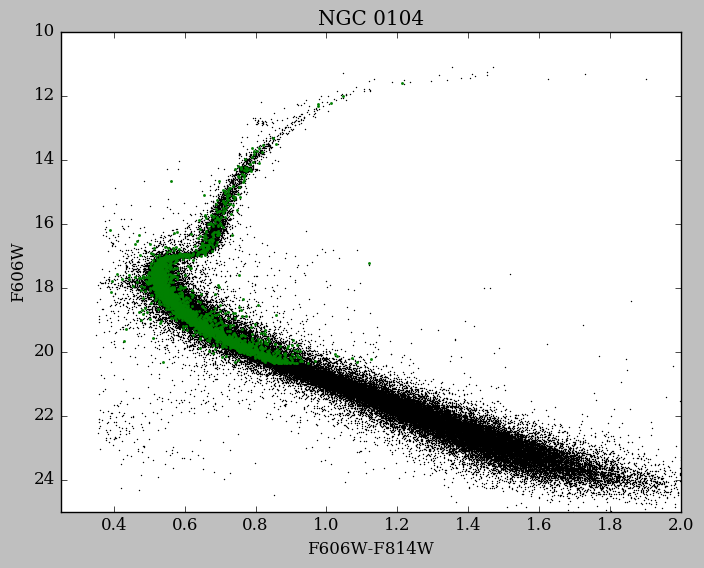

In [8]:
xlim(.25,2);ylim(10,25)
ACSpipe1.check_sample()

Now, you have files formatted for ease of use with BASE-9 singlePopMcmc. **You will need the BASE-9 software and DSED isochrone models successfully downloaded and installed to perform the Bayesian analysis**. It is assumed in the next section that this has occurred and the appropriate .yaml and .res files have been edited/generated by the user.

<br/>
<br/>

### Post-Computation Analysis
In this section, we assume that BASE-9 has been successfully run (specifically, singlePopMcmc) with the sample photometry and result file is named in the format of NGC####.v#.res in the NGC#### folder. In the example case, this is NGC0104/NGC0104.v2.res. The 'v2' is utilized for user version control/organization of BASE-9 results.

To plot the MCMC chains for the example results, we pass '2' (for 'v2') to the function plot_MCMCresults(). We not only get a visualization of the Adaptive Metropolis MCMC sampling chain (left) but the resulting posterior distribution as well (right).

Each row shows the results for a different parameter - age (log10 space), metallicity ([Fe/H]), distance modulus, absorption (Av), and helium (Y). Metallicity has been assumed to be a specific value, so we obviously see no change there. We note here that age (aka log10 age) has the only non-Gaussian posterior distribution -- we have limited the upper age limit to be 10.1303337685 (13.5 Gyr) to be comparable to the age of the Universe (~13.5 to 13.8 Gyr).

The posterior distributions also show a solid line, which indicates the median of the posterior distribution. The blue dotted lines to either side show the 90% Bayesian credible interval. The user has some control over whether the plot shows the entire sampling history, whether to plot the initial prior distributions, and whether a LaTeX-formatted table is provided with the results.

              median      90% Confidence Interval
log(age)      10.1301     10.1295    10.1303
[Fe/H]        -0.72     -0.72    -0.72
Dist Mod      13.3781     13.3738    13.3824
A$_{V}$       0.1047     0.1029    0.1066
Y             0.271     0.2682    0.2739


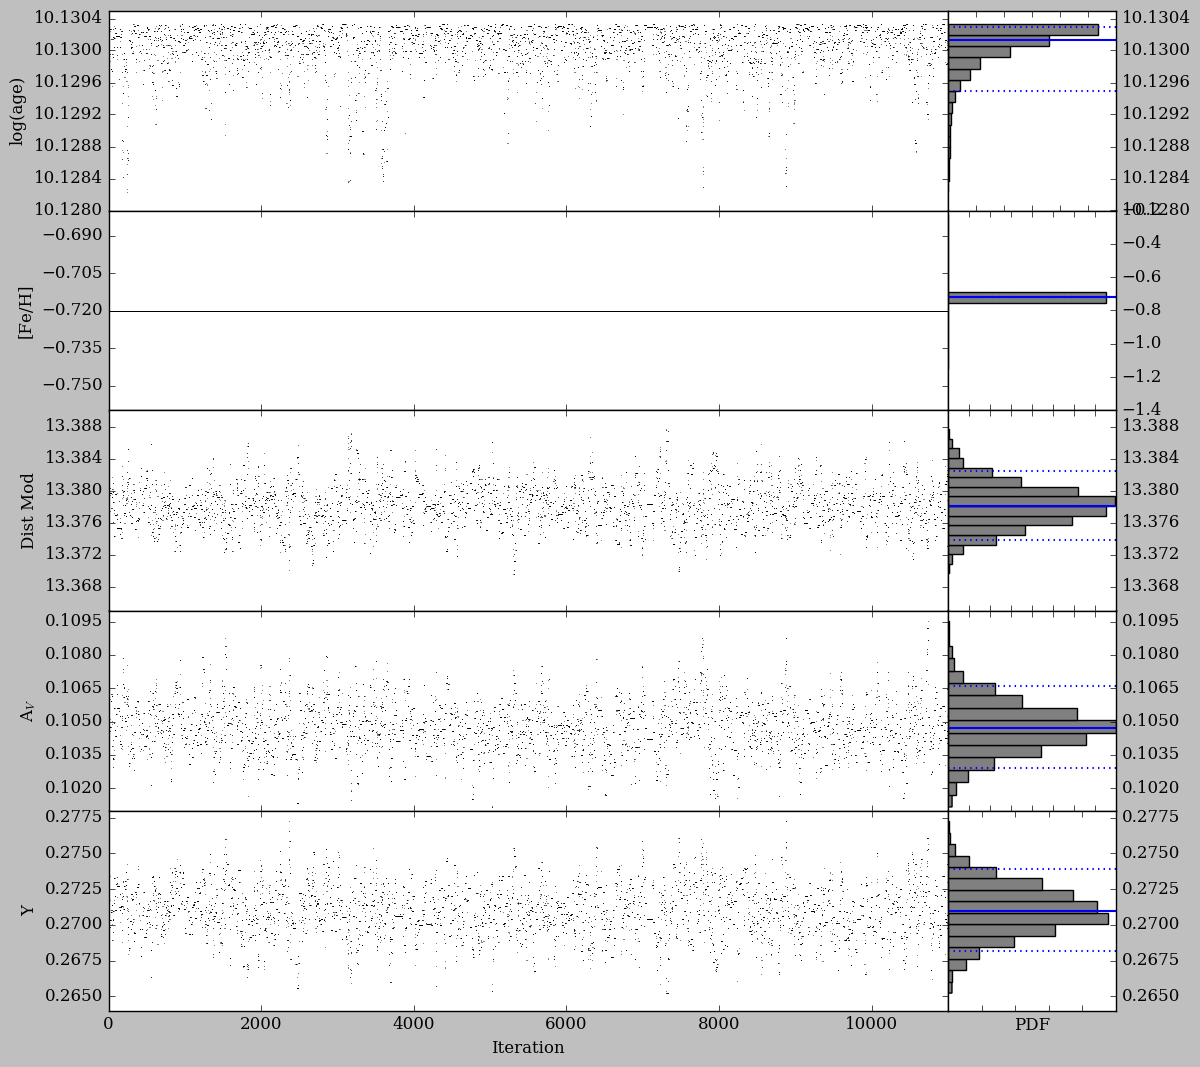

In [10]:
ACSpipe1.plot_MCMCresults('2')

<br/>
Now, if the user wants to generate an isochrone from the results, a value must be chosen to represent each parameter. We choose the median to represent the posterior distribution for each parameter, and use these values to generate an isochrone representative of the Bayesian analysis from the BASE-9 software.

Assuming these values, the run_makeCMD() function takes the version control number (e.g.: v2 from above) for the results file of interest. In this example, that is the NGC0104/NGC0104.v2.res file from BASE-9, and we pass '2' to the function.

It is strongly suggested that when .yaml files are not in use they be saved as base9_NNNN.yaml, where NNNN is the cluster identifer (without NGC). This is where makeCMD() will look to find the .yaml files with the correct cluster parameters already in place.

The makeCMD() function then copies the base9_0104.yaml file to a new base9.yaml file, while inputting the medians of the posterior distributions pulled from the results file into their proper place. Note that this **will** overwrite any base9.yaml file that already exists in your filepath.

On the other hand, you can now go directly to the terminal window in that folder and run ./makeCMD in BASE-9 to now generate the isochrone.

In [11]:
#### run makeCMD from command line
ACSpipe1.run_makeCMD('2')

[-0.71999999999999997, 13.37809, 0.104717, 0.270982, 10.130129]


<br/>
Now there should be a NGC0104/NGC0104.v2.ms file which is the generated isochrone (a NGC0104/NGC0104.v2.wd file will also be created for white dwarfs, but this is not presently included in the HST/ACS Globular Cluster Treasury analysis).

The plot_CMDresults() function, demonstrated below, shows the final results of this computation alongside the cleaned (gray) and sample (black) photometry.

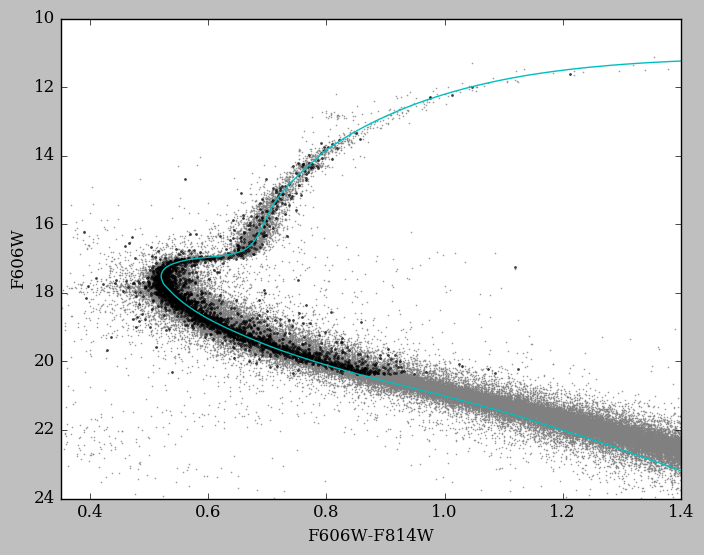

In [13]:
xlim(0.35,1.4);ylim(10,24)
ACSpipe1.plot_CMDresults('2')

<br/>
<br/>
### Summary

That is a non-exhaustive summary and example test case of how the processing and analysis pipeline works. In practice, there are additional user options not discussed here that can be imposed (e.g.: if Y is not a sampled parameter). Additional information on this ACSpipe package can be found in the source code, function descriptions, or from contacting myself.

Further information on the installation of BASE-9, the use of BASE-9, or the statistical underpinnings of the code can be found at the links below.